#### Influencer

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import col

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
%%time
twitter = spark.read.parquet('gs://chen26-bdp/original_data')

CPU times: user 7.42 ms, sys: 3.87 ms, total: 11.3 ms
Wall time: 7.96 s


23/03/05 03:12:14 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# original posts

In [5]:
keywords = ['college', 'high', 'university', 'students'
            , 'public', 'private', 'secondary', 'primary', 'education', 'undergraduate','graduate']
twitter = twitter.withColumn('lower', lower(col('text')))
filter_twitter = twitter.filter(col('lower').rlike('|'.join(keywords)))
twitter_eng = filter_twitter.filter(col('lang') == 'en')
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
tweets = twitter_eng.filter(filter_udf(eng_ord('text')) == True)

In [11]:
data = tweets.select('user','created_at','extended_tweet','retweeted_status','text','id','retweeted_from')

In [12]:
data = data.withColumn("user_id", col("user").getItem("id")).\
            withColumn('user_name', col('user').getItem('screen_name')).\
            withColumn('user_loc',col('user').getItem('location')).\
            withColumn('user_descrip',col('user').getItem('description')).\
            withColumn('user_followerct',col('user').getItem('followers_count')).\
            select('user_id', 'user_name', 'user_loc', 'user_descrip','user_followerct',
            'created_at','text','extended_tweet','retweeted_status','id','retweeted_from')

In [13]:
data = data.withColumn('retweet_ct', col('retweeted_status').getItem('retweet_count')).\
            withColumn('retweet', col('retweeted_status').getItem('retweeted')).drop('retweeted_status')

In [15]:
data = data.withColumn('full_text',col('extended_tweet').getItem('full_text')).drop('extended_tweet')

In [16]:
data = data.withColumn('full_text', coalesce(data.full_text, data.text))
data = data.drop('text')

In [17]:
original = data.filter(col('retweet').isNull())
retweet = data.filter(col('retweet').isNotNull())

In [18]:
ori_ct = original.groupby('user_id').count().sort(col('count').desc())
ori_ct.show()

+-------------------+-----+
|            user_id|count|
+-------------------+-----+
|1128225338775953408|12520|
|          219401992| 9201|
|1508968207259869185| 7769|
|           66263683| 6809|
|1576939116230455296| 6780|
|1577029442488061953| 6609|
|1463182041147576321| 6549|
| 879496394691805184| 6337|
|1582053513357537293| 6241|
|1473922978073165834| 6178|
|1422259384525090818| 6039|
|1338108136561856517| 5823|
|1214364378150998019| 5776|
|1597301580914601985| 5658|
|           73707872| 5624|
|1329639203144011776| 5289|
|          901030512| 5263|
|1472159008886870028| 5209|
|         2203526911| 5162|
|1468164097355264002| 5139|
+-------------------+-----+
only showing top 20 rows



In [19]:
ori_followerct = original.groupby('user_id').agg(max('user_followerct').alias('Max_reach'))
ori_followerct.show()

+-------------------+---------+
|            user_id|Max_reach|
+-------------------+---------+
|          726281982|       55|
|         2876988698|      115|
|         2883454026|      149|
|           44464351|      399|
|         2249344528|     1477|
|          632413348|      794|
|           51792862|      398|
|         1354752901|      764|
|         2944855720|       96|
|         4011593092|      315|
|1288857011732402182|       89|
|          161389551|    14911|
|         1595643056|      837|
|          501359563|       57|
|         4033589842|        5|
|          954659082|        2|
|          396940133|       83|
|         3167076418|      452|
|          229980955|      312|
|         4779708921|       72|
+-------------------+---------+
only showing top 20 rows



In [ ]:
ori_name = original.groupby('user_id').agg(max('user_name').alias('user_name'))
ori_name.show()

+-------+-------------+
|user_id|    user_name|
+-------+-------------+
|    414|         veen|
|    418|         dens|
|    926|  bradbarrish|
|   1497|       harper|
|   1547|      LizDunn|
|   2900|  jeffisageek|
|   3252|    odannyboy|
|   4509| andyabramson|
|   4603|        jem27|
|   4872|      bradlau|
|   5107|           mb|
|   7499|        Naija|
|   8264|       alicia|
|  10078|  reidhoffman|
|  10178|    stoweboyd|
|  10237|Chuckumentary|
|  10422|      pleitch|
|  10425|  courtneyrau|
|  10695|briansweeting|
|  10715|   dylanbland|
+-------+-------------+
only showing top 20 rows



In [21]:
user = ori_ct.join(ori_name, ori_ct.user_id == ori_name.user_id, 'inner').drop(ori_name['user_id'])

In [22]:
user.show()

+-----+-------+-------------+
|count|user_id|    user_name|
+-----+-------+-------------+
|    1|    414|         veen|
|    2|    418|         dens|
|    1|    926|  bradbarrish|
|    3|   1497|       harper|
|    1|   1547|      LizDunn|
|    1|   2900|  jeffisageek|
|    3|   3252|    odannyboy|
|    3|   4509| andyabramson|
|    2|   4603|        jem27|
|    1|   4872|      bradlau|
|    1|   5107|           mb|
|    1|   7499|        Naija|
|    4|   8264|       alicia|
|    4|  10078|  reidhoffman|
|    1|  10178|    stoweboyd|
|    4|  10237|Chuckumentary|
|    1|  10422|      pleitch|
|    3|  10425|  courtneyrau|
|    1|  10695|briansweeting|
|    1|  10715|   dylanbland|
+-----+-------+-------------+
only showing top 20 rows



In [ ]:
user_df = user.join(ori_followerct, user.user_id == ori_followerct.user_id, 'inner').drop(ori_followerct['user_id'])
user_df.show()

+-----+-------+-------------+---------+
|count|user_id|    user_name|Max_reach|
+-----+-------+-------------+---------+
|    1|    414|         veen|    39559|
|    2|    418|         dens|    83191|
|    1|    926|  bradbarrish|     2822|
|    3|   1497|       harper|    38084|
|    1|   1547|      LizDunn|     1525|
|    1|   2900|  jeffisageek|     8083|
|    3|   3252|    odannyboy|    31824|
|    3|   4509| andyabramson|     6392|
|    2|   4603|        jem27|      124|
|    1|   4872|      bradlau|     1240|
|    1|   5107|           mb|     7998|
|    1|   7499|        Naija|     4668|
|    4|   8264|       alicia|     4879|
|    4|  10078|  reidhoffman|   652434|
|    1|  10178|    stoweboyd|    19020|
|    4|  10237|Chuckumentary|    10314|
|    1|  10422|      pleitch|     1116|
|    3|  10425|  courtneyrau|      332|
|    1|  10695|briansweeting|      606|
|    1|  10715|   dylanbland|     1289|
+-----+-------+-------------+---------+
only showing top 20 rows



In [26]:
ori_des = original.groupby('user_id').agg(max('user_descrip').alias('user_descrip'))

In [27]:
user_df = user_df.join(ori_des, user.user_id == ori_des.user_id, 'inner').drop(ori_des['user_id'])

In [ ]:
user_df

count,user_id,user_name,Max_reach,user_descrip
2,418,dens,83191,I like to build t...
1,926,bradbarrish,2822,Internet adventur...
3,3252,odannyboy,31824,ex-Head of Produc...
3,4509,andyabramson,6392,Always Asymmetric...
1,10178,stoweboyd,19020,"The past, present..."
4,10237,Chuckumentary,10314,boreal human with...
1,10422,pleitch,1116,i like buying rec...
1,10695,briansweeting,606,"Product design, d..."
1,11574,Dredaye_89,1909,Check the year I...
2,12085,dk,3267,Social Media. Blo...


In [29]:
ret_ct = retweet.groupby('full_text').agg(max('retweet_ct').alias('retweet_ct'))
ret_user = ret_ct.join(retweet, ret_ct.full_text==retweet.full_text,'left').\
select(ret_ct.full_text,ret_ct.retweet_ct,'retweeted_from')
ret_user = ret_user.dropDuplicates()
ret_user_sum = ret_user.groupby('retweeted_from').agg(sum('retweet_ct').alias('total_rct'))
user_rtc = user_df.join(ret_user_sum, user_df.user_name == ret_user_sum.retweeted_from, 'inner').\
drop(ret_user_sum['retweeted_from'])

In [ ]:
user_rtc.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/infl')

In [6]:
influencer = spark.read.parquet('gs://chen26-bdp/infl')

In [7]:
influencer.orderBy(col('total_rct').desc())

count,user_id,user_name,Max_reach,user_descrip,total_rct
52,1326229737551912960,libsoftiktok,1893691,Bringing you news...,482067
17,878284831,OccupyDemocrats,504212,Pro-Democrat poli...,414295
17,3317348164,NasimiShabnam,71862,Policy Special Ad...,293392
15,1268223690480615424,NoLieWithBTC,338956,Podcast covering ...,291413
10,26257166,SportsCenter,41400369,Download the ESPN...,250517
49,1915033663,davidhogg111,1267103,Supposedly a “mul...,206630
51,286998245,Phil_Lewis_,300076,detroit native. s...,197817
1,14335586,Public_Citizen,535244,Public Citizen ha...,193203
1,576320750,JonWTOL,2973,NW Ohio native. R...,185946
13,1016021178,ColIegeStudent,1876945,Contact: CollegeS...,181667


In [8]:
veri = tweets.select([tweets.user['id'].alias('user_id'),
               tweets.user['verified'].alias('verified')])

In [10]:
veri = veri.dropDuplicates(['user_id'])

In [13]:
user_veri = influencer.join(veri, influencer.user_id == veri.user_id, 'inner').drop(veri.user_id)

In [15]:
user_veri.orderBy(col('total_rct').desc())

count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
52,1326229737551912960,libsoftiktok,1893691,Bringing you news...,482067,false
17,878284831,OccupyDemocrats,504212,Pro-Democrat poli...,414295,true
17,3317348164,NasimiShabnam,71862,Policy Special Ad...,293392,true
15,1268223690480615424,NoLieWithBTC,338956,Podcast covering ...,291413,true
10,26257166,SportsCenter,41400369,Download the ESPN...,250517,true
49,1915033663,davidhogg111,1267103,Supposedly a “mul...,206630,true
51,286998245,Phil_Lewis_,300076,detroit native. s...,197817,true
1,14335586,Public_Citizen,535244,Public Citizen ha...,193203,true
1,576320750,JonWTOL,2973,NW Ohio native. R...,185946,true
13,1016021178,ColIegeStudent,1876945,Contact: CollegeS...,181667,false


In [16]:
verify = user_veri.filter(col('verified') == 'true')
unverify = user_veri.filter(col('verified') == 'false')

In [17]:
top50_verify_original = verify.orderBy(col('count').desc()).limit(50)

In [18]:
v = top50_verify_original.toPandas()

In [19]:
v

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,3149,2868388510,sportsthread,208834,"‼️Sports Thread is the bridge to your college home🎓 Post🔥highlights on our app to be featured. Also, be 👀 by more college coaches and fans on Sports Thread🏆",73,True
1,1094,19025957,TTCnotices,429486,Service alerts from TTC Transit Control. Follow @TTChelps for customer service.,1646,True
2,748,30846824,TOICitiesNews,27844,Unmatched coverage from over 60 cities across India brought to you by http://timesofindia.com,1134,True
3,730,19616718,USNewsEducation,332590,Education news and rankings from U.S. News & World Report.,1068,True
4,707,113388430,SF_England,127004,📄 Terms of Use http://ow.ly/QFXJ50zF8YD \n📍 For Repayment queries @SLC_Repayment,29,True
5,706,34324846,ScienceCareers,167516,ScienceCareers is the careers component of @ScienceMagazine and produced by @AAAS. Scientists rely on Science Careers for #career information and #job postings.,290,True
6,647,12952842,MLive,380150,http://MLive.com ||| Michigan’s largest local news site. ✋👈\nJoin us on Mastodon @mlive@mstdn.social,442,True
7,635,28942750,MARTAservice,27515,"Service information, alerts, & customer service for @MARTAtransit.\n\nReport a problem: https://itsmarta.com/ht_login.aspx\n\nEmergencies: 404-848-4911",43,True
8,609,14662354,WashTimes,447359,"Reliable reporting, hard-hitting analysis & breaking news, plus RTs from our writers and reporters. Also at @WashTimesOpEd, @WashTimesLocal, @WashTimesSports",5299,True
9,571,23602600,timeshighered,317632,"Global HE news, data, insights and events. Home of @THEWorldUniRank, @THEworldsummits, best practice at THE Campus, and @THEuniadvice for students.",4188,True


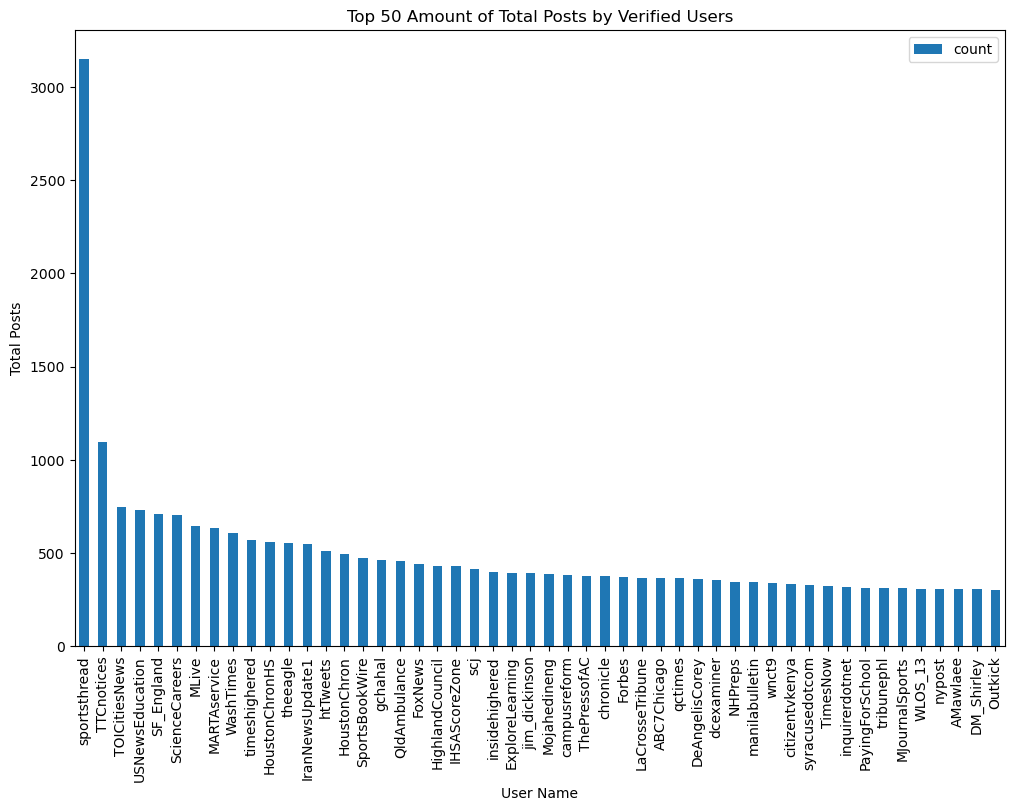

In [21]:
ax = v.plot(x='user_name', y= 'count', kind='bar', figsize = (12, 8))

ax.set_xlabel('User Name')
ax.set_ylabel('Total Posts')
ax.set_title('Top 50 Amount of Total Posts by Verified Users')

# show the plot
plt.show()

In [22]:
top50_unverify_original = unverify.orderBy(col('count').desc()).limit(50)

In [23]:
uv = top50_unverify_original.toPandas()

In [24]:
uv

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,12520,1128225338775953408,AndrianyRahmah,218,hs game update news,13,False
1,9201,219401992,DennisStemmle,3804,"Founder - College Success Academy, #1 Best-Selling Author, Entrepreneur, Speaker, Lecturer at The Wall College of Business - Coastal Carolina University",410,False
2,7769,1508968207259869185,hilmsit,353,𝐋𝐈𝐕𝐄 𝐒𝐓𝐑𝐄𝐀𝐌𝐈𝐍𝐆 🔴 High School Today,17,False
3,6809,66263683,NJSchoolJobs,4252,The leading advertiser of education jobs for New Jersey's Schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,540,False
4,6780,1576939116230455296,dini92276801,84,None,6,False
5,6609,1577029442488061953,TeriWini,37,None,1,False
6,6549,1463182041147576321,sport9920,95,"Welcom TV listing for all\nEnjoy your watching live sports - Football,Basketball and more (Click the link below the description)",69,False
7,6337,879496394691805184,EssayPaperUK,803,I AM The Documentary,3,False
8,6241,1582053513357537293,qiopalika,18,None,3,False
9,6178,1473922978073165834,studyinnaija,48,"Find All Private & Public Universities, Colleges and TVETs and Courses Offered in Nigeria.",5,False


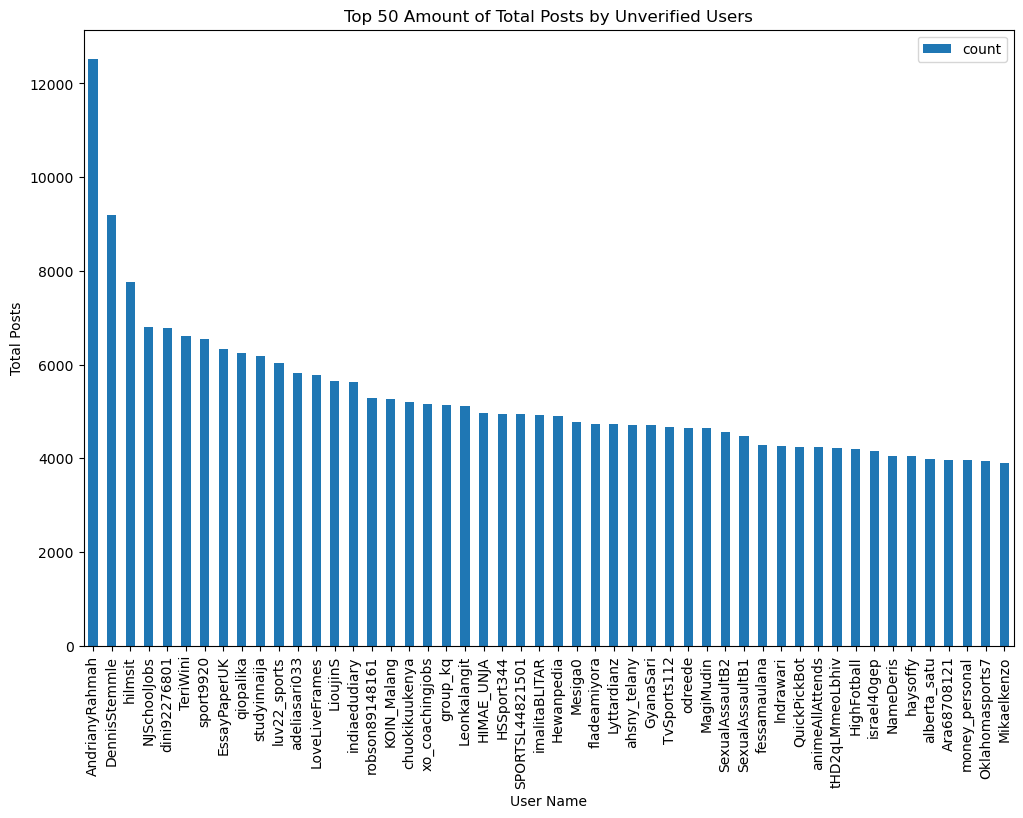

In [25]:
ax = uv.plot(x='user_name', y= 'count', kind='bar', figsize = (12, 8))

ax.set_xlabel('User Name')
ax.set_ylabel('Total Posts')
ax.set_title('Top 50 Amount of Total Posts by Unverified Users')

# show the plot
plt.show()

In [26]:
top50_ori = user_veri.orderBy(col('count').desc()).limit(50)

In [ ]:
top50 = top50_ori.toPandas()

In [28]:
top50

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,12520,1128225338775953408,AndrianyRahmah,218,hs game update news,13,False
1,9201,219401992,DennisStemmle,3804,"Founder - College Success Academy, #1 Best-Selling Author, Entrepreneur, Speaker, Lecturer at The Wall College of Business - Coastal Carolina University",410,False
2,7769,1508968207259869185,hilmsit,353,𝐋𝐈𝐕𝐄 𝐒𝐓𝐑𝐄𝐀𝐌𝐈𝐍𝐆 🔴 High School Today,17,False
3,6809,66263683,NJSchoolJobs,4252,The leading advertiser of education jobs for New Jersey's Schools since 1999! #nj #teaching #administrative #coaching #education #teachingjobs #newjersey,540,False
4,6780,1576939116230455296,dini92276801,84,None,6,False
5,6609,1577029442488061953,TeriWini,37,None,1,False
6,6549,1463182041147576321,sport9920,95,"Welcom TV listing for all\nEnjoy your watching live sports - Football,Basketball and more (Click the link below the description)",69,False
7,6337,879496394691805184,EssayPaperUK,803,I AM The Documentary,3,False
8,6241,1582053513357537293,qiopalika,18,None,3,False
9,6178,1473922978073165834,studyinnaija,48,"Find All Private & Public Universities, Colleges and TVETs and Courses Offered in Nigeria.",5,False


In [29]:
# top retweeted
top50_rt = user_veri.orderBy(col('total_rct').desc()).limit(50)
top50_rt_df = top50_rt.toPandas()

In [30]:
top50_rt_df

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,52,1326229737551912960,libsoftiktok,1893691,Bringing you news you won’t see anywhere else. All videos belong to their respective owners. 📧 libsoftiktok@gmail.com. DM submissions,482067,False
1,17,878284831,OccupyDemocrats,504212,Pro-Democrat political organization & news website. NY Times reported that our reach dominated Trump on Facebook before his ban. Founder: @OmarRiverosays,414295,True
2,17,3317348164,NasimiShabnam,71862,Policy Special Advisor to the UK Minister of State for Refugees. Agent: info@theblairpartnership.com 🇬🇧 @TBP_agency,293392,True
3,15,1268223690480615424,NoLieWithBTC,338956,Podcast covering the top stories & interviews with the biggest names in politics. Hosted by @briantylercohen,291413,True
4,10,26257166,SportsCenter,41400369,Download the ESPN App ⬇️,250517,True
5,49,1915033663,davidhogg111,1267103,"Supposedly a “multi-millionaire, American spy, and paid actor” contactdavidhogg@gmail.com",206630,True
6,51,286998245,Phil_Lewis_,300076,detroit native. senior front page editor @huffpost. subscribe to my newsletter! 👇🏾,197817,True
7,1,14335586,Public_Citizen,535244,Public Citizen has been standing up to corporate power and holding government accountable for 50 years. We're people-powered and accept no corporate money.,193203,True
8,1,576320750,JonWTOL,2973,NW Ohio native. Reporter/Photographer for @WTOL11Toledo and @Go_419,185946,True
9,13,1016021178,ColIegeStudent,1876945,Contact: CollegeStudentofficial@gmail.com,181667,False


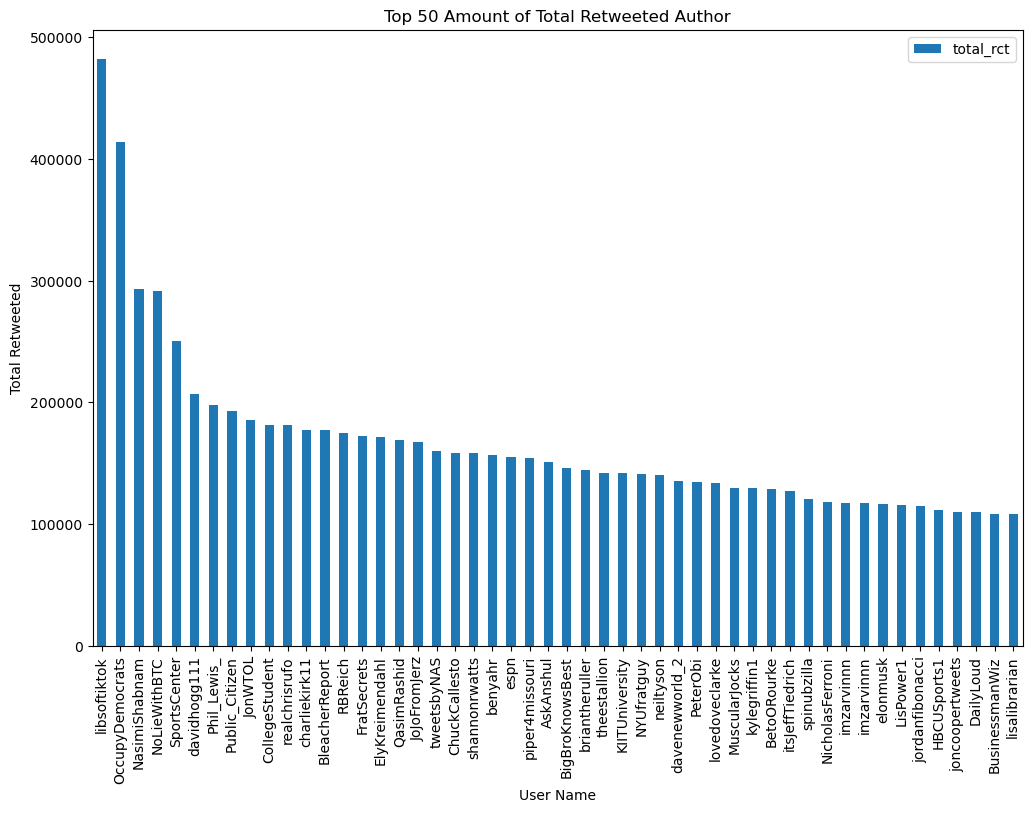

In [32]:
ax = top50_rt_df.plot(x='user_name', y= 'total_rct', kind='bar', figsize = (12, 8))

ax.set_xlabel('User Name')
ax.set_ylabel('Total Retweeted')
ax.set_title('Top 50 Amount of Total Retweeted Author')

# show the plot
plt.show()

In [33]:
# top retweeted verify
rt_verify = user_veri.filter(col('verified') == 'true')
top50_rt_v = rt_verify.orderBy(col('total_rct').desc()).limit(50)
top50_rt_v_df = top50_rt_v.toPandas()

In [34]:
top50_rt_v_df

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,17,878284831,OccupyDemocrats,504212,Pro-Democrat political organization & news website. NY Times reported that our reach dominated Trump on Facebook before his ban. Founder: @OmarRiverosays,414295,True
1,17,3317348164,NasimiShabnam,71862,Policy Special Advisor to the UK Minister of State for Refugees. Agent: info@theblairpartnership.com 🇬🇧 @TBP_agency,293392,True
2,15,1268223690480615424,NoLieWithBTC,338956,Podcast covering the top stories & interviews with the biggest names in politics. Hosted by @briantylercohen,291413,True
3,10,26257166,SportsCenter,41400369,Download the ESPN App ⬇️,250517,True
4,49,1915033663,davidhogg111,1267103,"Supposedly a “multi-millionaire, American spy, and paid actor” contactdavidhogg@gmail.com",206630,True
5,51,286998245,Phil_Lewis_,300076,detroit native. senior front page editor @huffpost. subscribe to my newsletter! 👇🏾,197817,True
6,1,14335586,Public_Citizen,535244,Public Citizen has been standing up to corporate power and holding government accountable for 50 years. We're people-powered and accept no corporate money.,193203,True
7,1,576320750,JonWTOL,2973,NW Ohio native. Reporter/Photographer for @WTOL11Toledo and @Go_419,185946,True
8,66,3066800573,realchrisrufo,490037,"Writer, filmmaker, activist. Manhattan Institute and City Journal. Sign up for my newsletter: http://christopherrufo.com/newsletter.",181261,True
9,10,292929271,charliekirk11,1912374,Founder & President: @TPUSA • Host: The Charlie Kirk Show • Click the link below to subscribe 🇺🇸,177580,True


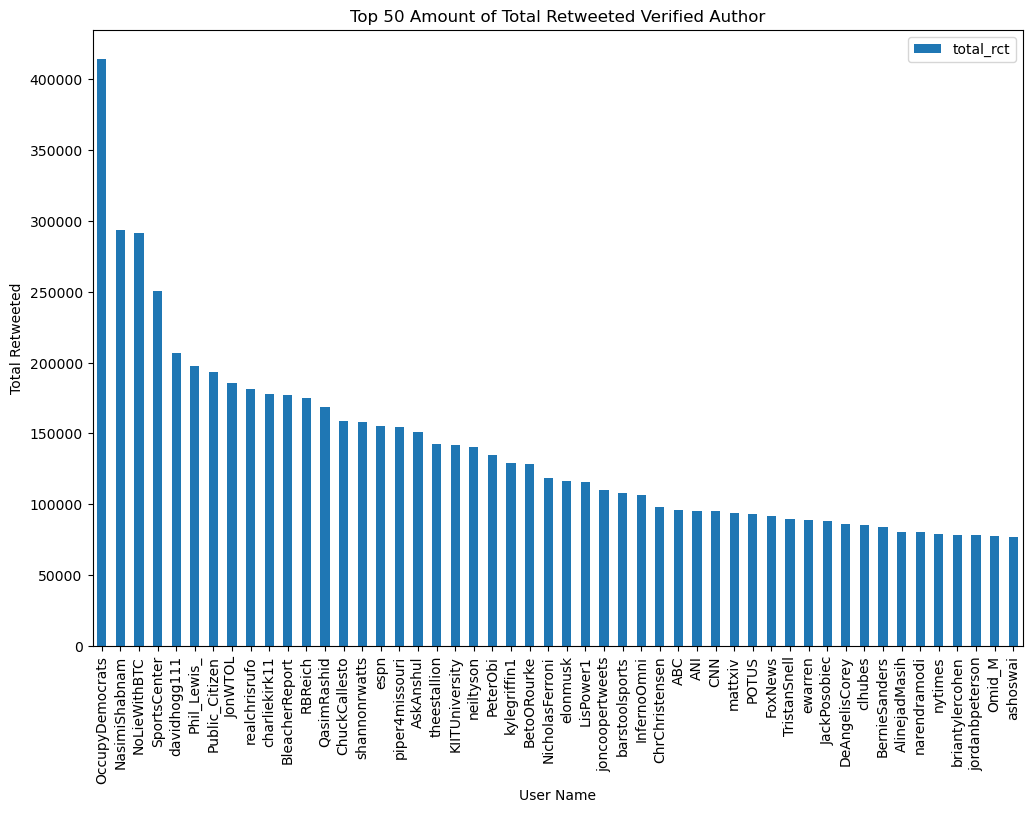

In [35]:
ax = top50_rt_v_df.plot(x='user_name', y= 'total_rct', kind='bar', figsize = (12, 8))

ax.set_xlabel('User Name')
ax.set_ylabel('Total Retweeted')
ax.set_title('Top 50 Amount of Total Retweeted Verified Author')

# show the plot
plt.show()

In [36]:
# top retweeted verify
rt_unverify = user_veri.filter(col('verified') == 'false')
top50_rt_uv = rt_unverify.orderBy(col('total_rct').desc()).limit(50)
top50_rt_uv_df = top50_rt_uv.toPandas()

In [37]:
top50_rt_uv_df

,count,user_id,user_name,Max_reach,user_descrip,total_rct,verified
0,52,1326229737551912960,libsoftiktok,1893691,Bringing you news you won’t see anywhere else. All videos belong to their respective owners. 📧 libsoftiktok@gmail.com. DM submissions,482067,False
1,13,1016021178,ColIegeStudent,1876945,Contact: CollegeStudentofficial@gmail.com,181667,False
2,71,1507068807038349314,FratSecrets,381302,Being a part of the brotherhood means we keep each other’s secrets 🤐,172417,False
3,10,1225603175748685824,ElyKreimendahl,147400,"writer, comic, queer. i live tweeted the birth of my baby. @funnyordie @newrootsartists @humordarling mgmt: waldorf entertainment",171951,False
4,26,818893114979061761,JoJoFromJerz,758665,jersey. democrat. news junkie. lover of puns. Lebanese. hothead. mom. geek. Blocked by Chachi. http://jojofromjerz.com. https://ko-fi.com/jojofromjerz,167801,False
5,1,119458432,tweetsbyNAS,1343,"It matters now, but not here. ♉︎☉ ♒︎☾",160350,False
6,2,24996233,benyahr,44328,Goofball | Actress | Short King | Lip Sync Assassin | http://www.Instagram.com/benyahr,156440,False
7,41,1246599649835786244,BigBroKnowsBest,607135,One thing I’ve learned is that my older brother knows best.,146182,False
8,1,1442696255025582084,briantheruller,203634,turn notis on,144214,False
9,44,1243266944226201606,NYUfratguy,484656,21 year old college athlete at NYU. Kapa Sigma. Looking for my little bro 😎,141225,False


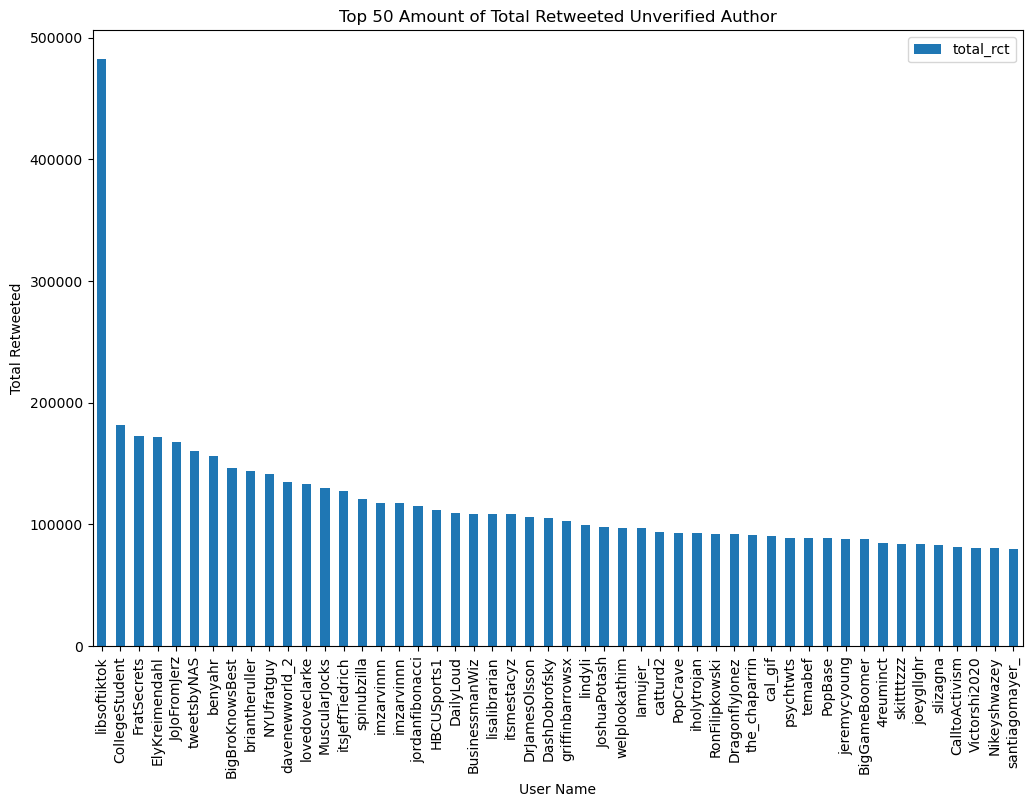

In [38]:
ax = top50_rt_uv_df.plot(x='user_name', y= 'total_rct', kind='bar', figsize = (12, 8))

ax.set_xlabel('User Name')
ax.set_ylabel('Total Retweeted')
ax.set_title('Top 50 Amount of Total Retweeted Unverified Author')

# show the plot
plt.show()